# Modelling - Regression

In this notebook, I perform regression to get the line of best fit for each cluster and subsequently, determine at which unit price range will the transaction likely to be profitable. 

**Contents:**
- [Imports](#Import-libraries-and-data)
- [Preprocessing](#Preprocessing)
- [Modelling](#Modellin)
    - [Cluster 1](#Cluster-1)
    - [Cluster 2](#Cluster-2)
    - [Cluster 3](#Cluster-3)
- [Conclusion and Recommendation](#Conclusion-and-Recommendation)
- [Limitations and Other Considerations](#Limitations-and-Other-Considerations)

### Import libraries and data

In [1]:
#import libraries
import numpy as np
import pandas as pd 
pd.set_option('display.max_columns', None)
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from prettytable import PrettyTable
import warnings
warnings.filterwarnings('ignore')

# imports for preprocessing
from sklearn.preprocessing import StandardScaler
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectKBest, f_regression

# imports for modelling
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.pipeline import Pipeline

%matplotlib inline

In [2]:
#read data
phones = pd.read_csv("../data/phones_clustered.csv")
print("=================== Top 5 rows of dataset ===================")
display(phones.head())
print("=================== Shape of dataset ===================")
print(phones.shape)
print("=================== Data types in dataset ===================")
print(phones.dtypes)
print("=================== Description of data in dataset ===================")
display(phones.describe())

=================== Top 5 rows of dataset ===================


,sales,profit,shipping_cost,unit_price,quantity,discount,heavy_discount_regions,non_profitable_regions,more_qty,cluster
0,221.980,62.1544,40.770,110.990,2,0.0,0,0,0,2
1,668.160,75.1680,45.740,74.240,9,0.2,0,0,1,1
2,2043.720,756.0000,321.360,145.980,14,0.0,0,0,1,1
3,2125.000,297.5000,316.764,425.000,5,0.0,0,0,1,1
4,470.376,52.9173,137.410,156.792,3,0.2,0,0,1,1


=================== Shape of dataset ===================
(3073, 10)
=================== Data types in dataset ===================
sales                     float64
profit                    float64
shipping_cost             float64
unit_price                float64
quantity                    int64
discount                  float64
heavy_discount_regions      int64
non_profitable_regions      int64
more_qty                    int64
cluster                     int64
dtype: object
=================== Description of data in dataset ===================


,sales,profit,shipping_cost,unit_price,quantity,discount,heavy_discount_regions,non_profitable_regions,more_qty,cluster
count,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000
mean,364.724233,40.863466,38.492055,109.098274,3.491702,0.148994,0.069639,0.069639,0.600390,1.485844
std,376.282197,118.699060,46.799308,94.828719,2.228196,0.189178,0.254579,0.254579,0.489898,0.623862
min,2.970000,-685.752000,1.050000,1.584000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,126.090000,1.198800,9.710000,51.992000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,249.060000,27.196000,21.700000,83.862000,3.000000,0.100000,0.000000,0.000000,1.000000,1.000000
75%,459.360000,77.550000,47.160000,136.650000,5.000000,0.200000,0.000000,0.000000,1.000000,2.000000
max,2616.960000,756.000000,321.360000,587.412000,14.000000,0.700000,1.000000,1.000000,1.000000,3.000000


In [3]:
# view profiit per unit
phones['profit_per_unit'] = phones['profit']/phones['quantity']

### Preprocessing
Here I separate out each cluster into separate dataframes and do a train-test split, in preparation for modelling. 

In [4]:
# create dataframes for each cluster
cluster1 = phones[phones['cluster']==1]
cluster2 = phones[phones['cluster']==2]
cluster3 = phones[phones['cluster']==3]

In [5]:
# create features and target
cluster1.drop(columns = ['cluster'], inplace=True)
features = [col for col in cluster1.columns if col != 'profit_per_unit']
X1 = cluster1[features]
y1 = cluster1['profit_per_unit']

cluster2.drop(columns = ['cluster'], inplace=True)
features = [col for col in cluster2.columns if col != 'profit_per_unit']
X2 = cluster2[features]
y2 = cluster2['profit_per_unit']

cluster3.drop(columns = ['cluster'], inplace=True)
features = [col for col in cluster2.columns if col != 'profit_per_unit']
X3 = cluster3[features]
y3 = cluster3['profit_per_unit']

In [6]:
# split data into train and test set
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, random_state = 42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state = 42)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, random_state = 42)

### Modelling
Nested cross-validation to select the algorithm to use. 

In [7]:
# instantiate regressors
enet = ElasticNetCV()
rfr = RandomForestRegressor(max_features='auto')
svr = SVR(kernel='linear',epsilon=0.2)
xgbr = XGBRegressor()
lasso = LassoCV()
ridge = RidgeCV()

In [8]:
# build pipeline
p1 = Pipeline([('ss', StandardScaler()),
               ('enet', enet)])

p2 = Pipeline([('ss', StandardScaler()),
#                ('skb', SelectKBest(score_func=f_regression, k=20)),
               ('rfr', rfr)])

p3 = Pipeline([('ss', StandardScaler()),
#                ('skb', SelectKBest(score_func=f_regression, k=20)),
               ('svr', svr)])

p4 = Pipeline([('ss', StandardScaler()),
#                ('skb', SelectKBest(score_func=f_regression, k=20)),
               ('xgbr', xgbr)])

p5 = Pipeline([('ss', StandardScaler()),
               ('lasso', lasso)])

p6 = Pipeline([('ss', StandardScaler()),
               ('ridge', ridge)])

In [9]:
# set up params
params1 = [{'enet__n_alphas':[200,300,400,500],
           'enet__l1_ratio':np.linspace(0.0001,1,100)}]

params2 = [{'rfr__n_estimators':[200,350,500],
            'rfr__max_depth':[2,5,10],
            'rfr__min_samples_split':[12,15,20]}]

params3 = [{'svr__gamma':[0.001,0.01,0.1,1]}]

params4 = [{'xgbr__n_estimators':[70,150,250],
            'xgbr__max_depth':[3,5,7],
            'xgbr__learning_rate':[0.01,0.05,0.1]}]

params5 = [{'lasso__n_alphas':[100, 200]}]

params6 = [{'ridge__alphas':np.linspace(.1, 10, 100)}]

In [10]:
# set up gridsearch for each algo
gridcvs = {}

inner_cv = KFold(n_splits=2, shuffle=True, random_state=42)

for paramgrid, estimator, name in zip((params1,params2,params3,params4,params5,params6),
                                     (p1,p2,p3,p4,p5,p6),
                                     ('Elastic Net CV','Random Forest Regressor','Support Vector Regressor','XGBoost Regressor','Lasso','Ridge')):
    gcv = GridSearchCV(estimator = estimator,
                      param_grid = paramgrid,
                      scoring = 'r2',
                      n_jobs=-1,
                      cv=inner_cv,
                      verbose=0,
                      refit=True)
    gridcvs[name] = gcv

### Cluster 1

In [11]:
# score on cluster 1
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

a1 = PrettyTable(title="Cross-validated R2 score", header_style='title', max_table_width=110)
a1.field_names =["Algorithms", "R2 score", "Standard Deviation"]
for name, gs_est in sorted(gridcvs.items()):
    nested_score = cross_val_score(gs_est,
                                  X=X1_train,
                                  y=y1_train,
                                  cv=outer_cv,
                                  scoring='r2',
                                  n_jobs=-1)
    a1.add_row([name, f'{round(nested_score.mean(),3)*100}%', f'+/- {round(nested_score.std(),3)*100}%'])
#print table
print(a1)

+----------------------------------------------------------+
|                 Cross-validated R2 score                 |
+--------------------------+----------+--------------------+
|        Algorithms        | R2 Score | Standard Deviation |
+--------------------------+----------+--------------------+
|      Elastic Net CV      |  88.3%   |      +/- 2.1%      |
|          Lasso           |  88.4%   |      +/- 2.1%      |
| Random Forest Regressor  |  96.0%   |      +/- 1.2%      |
|          Ridge           |   nan%   |      +/- nan%      |
| Support Vector Regressor |  88.2%   |      +/- 2.4%      |
|    XGBoost Regressor     |  99.0%   |      +/- 0.4%      |
+--------------------------+----------+--------------------+


While I ran several models, I am interested in those with interpretable values, so amongst these, I will only consider `Elastic Net CV`, `Lasso` and `Ridge` as the working model. 

From results above, tree-based algorithms work much better but for algorithms that allow interpretability, `Lasso` did the best, so I will use this as the working model for the test set.

In [13]:
# fitting a model to the whole training set using the "best" algorithm - cluster 1
best_algo1 = gridcvs['Lasso']

best_algo1.fit(X1_train, y1_train)
train_r2 = r2_score(y_true=y1_train, y_pred=best_algo1.predict(X1_train))
test_r2 = r2_score(y_true=y1_test, y_pred=best_algo1.predict(X1_test))

b1 = PrettyTable(title="Lasso Scores")
b1.add_row(["Average over CV folds", round(100*best_algo1.best_score_,3)])
b1.add_row(["Training R2 Score", round(100*train_r2,3)])
b1.add_row(["Test R2 Score", round(100*test_r2,3)])
print(b1)

print("----- Best Params --------")
print(gridcvs['Lasso'].best_params_)

+---------------------------------+
|           Lasso Scores          |
+-----------------------+---------+
|        Field 1        | Field 2 |
+-----------------------+---------+
| Average over CV folds |  88.015 |
|   Training R2 Score   |  88.823 |
|     Test R2 Score     |  88.848 |
+-----------------------+---------+
----- Best Params --------
{'lasso__n_alphas': 200}


Lasso model is able to account for 88% of variability in data. From the intercept and coefficients, regression equation is as below :

In [14]:
best_algo1.best_estimator_.named_steps['lasso'].coef_

array([-12.21787353,  27.49854999,   0.40412995,  11.75701996,
        -0.86764104,  -1.6033346 ,   0.        ,   0.        ,
         0.        ])

In [15]:
best_algo1.best_estimator_.named_steps['lasso'].intercept_

12.840023717472116

**Regression equation for Cluster 1**

`profit_per_unit` = 12.84 - 12.21`sales` + 27.5`profit` + 0.40`shipping cost` + 11.8`unit price` - 0.86`quantity` - 1.60`discount`

### Cluster 2

In [17]:
#score on cluster 2
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

a2 = PrettyTable(title="Cross-validated R2 score", header_style='title', max_table_width=110)
a2.field_names =["Algorithms", "R2 score", "Standard Deviation"]
for name, gs_est in sorted(gridcvs.items()):
    nested_score = cross_val_score(gs_est,
                                  X=X2_train,
                                  y=y2_train,
                                  cv=outer_cv,
                                  n_jobs=-1)
    a2.add_row([name, f'{round(nested_score.mean(),3)*100}%', f'+/- {round(nested_score.std(),3)*100}%'])
#print table
print(a2)

+--------------------------------------------------------------------+
|                      Cross-validated R2 score                      |
+--------------------------+--------------------+--------------------+
|        Algorithms        |      R2 Score      | Standard Deviation |
+--------------------------+--------------------+--------------------+
|      Elastic Net CV      |       92.4%        |      +/- 2.7%      |
|          Lasso           |       92.5%        |      +/- 2.7%      |
| Random Forest Regressor  |       94.8%        |      +/- 0.6%      |
|          Ridge           |        nan%        |      +/- nan%      |
| Support Vector Regressor |       92.4%        |      +/- 2.4%      |
|    XGBoost Regressor     | 97.39999999999999% |      +/- 1.2%      |
+--------------------------+--------------------+--------------------+


In [21]:
# fitting a model to the whole training set using the "best" algorithm - cluster 1
best_algo2 = gridcvs['Lasso']

best_algo2.fit(X2_train, y2_train)
train_r2 = r2_score(y_true=y2_train, y_pred=best_algo2.predict(X2_train))
test_r2 = r2_score(y_true=y2_test, y_pred=best_algo2.predict(X2_test))

b1 = PrettyTable(title="Lasso Scores")
b1.add_row(["Average over CV folds", round(100*best_algo2.best_score_,3)])
b1.add_row(["Training R2 Score", round(100*train_r2,3)])
b1.add_row(["Test R2 Score", round(100*test_r2,3)])
print(b1)

print("----- Best Params --------")
print(gridcvs['Lasso'].best_params_)

+---------------------------------+
|           Lasso Scores          |
+-----------------------+---------+
|        Field 1        | Field 2 |
+-----------------------+---------+
| Average over CV folds |  93.66  |
|   Training R2 Score   |  93.745 |
|     Test R2 Score     |  95.21  |
+-----------------------+---------+
----- Best Params --------
{'lasso__n_alphas': 200}


Lasso model is able to account for 95% of variability in data. From the intercept and coefficients, regression equation is as below :

In [22]:
best_algo2.best_estimator_.named_steps['lasso'].coef_

array([-10.12449337,  32.19749545,  -0.42968884,  10.28825047,
        -0.60422649,  -1.98470968,   0.        ,   0.        ,
         0.        ])

In [23]:
best_algo2.best_estimator_.named_steps['lasso'].intercept_

14.52031328320802

**Regression equation for Cluster 2**

`profit_per_unit` = 14.52 - 10.12`sales` + 32.19`profit` - 0.42`shipping cost` + 10.28`unit price` - 0.6`quantity` - 1.98`discount`

### Cluster 3

In [24]:
#score on cluster 3
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

a3 = PrettyTable(title="Cross-validated R2 score", header_style='title', max_table_width=110)
a3.field_names =["Algorithms", "R2 score", "Standard Deviation"]
for name, gs_est in sorted(gridcvs.items()):
    nested_score = cross_val_score(gs_est,
                                  X=X3_train,
                                  y=y3_train,
                                  cv=outer_cv,
                                  n_jobs=-1)
    a3.add_row([name, f'{round(nested_score.mean(),3)*100}%', f'+/- {round(nested_score.std(),3)*100}%'])
#print table
print(a3)

+--------------------------------------------------------------------+
|                      Cross-validated R2 score                      |
+--------------------------+--------------------+--------------------+
|        Algorithms        |      R2 Score      | Standard Deviation |
+--------------------------+--------------------+--------------------+
|      Elastic Net CV      |       71.6%        |     +/- 10.5%      |
|          Lasso           | 70.89999999999999% |     +/- 11.1%      |
| Random Forest Regressor  |       90.5%        |      +/- 2.5%      |
|          Ridge           |        nan%        |      +/- nan%      |
| Support Vector Regressor |       72.7%        |      +/- 9.6%      |
|    XGBoost Regressor     | 92.80000000000001% |      +/- 1.3%      |
+--------------------------+--------------------+--------------------+


In [25]:
# fitting a model to the whole training set using the "best" algorithm - cluster 1
best_algo3 = gridcvs['Elastic Net CV']

best_algo3.fit(X3_train, y3_train)
train_r2 = r2_score(y_true=y3_train, y_pred=best_algo3.predict(X3_train))
test_r2 = r2_score(y_true=y3_test, y_pred=best_algo3.predict(X3_test))

b3 = PrettyTable(title="Elastic Net CV Scores")
b3.add_row(["Average over CV folds", round(100*best_algo3.best_score_,3)])
b3.add_row(["Training R2 Score", round(100*train_r2,3)])
b3.add_row(["Test R2 Score", round(100*test_r2,3)])
print(b3)

print("----- Best Params --------")
print(gridcvs['Elastic Net CV'].best_params_)

+---------------------------------+
|      Elastic Net CV Scores      |
+-----------------------+---------+
|        Field 1        | Field 2 |
+-----------------------+---------+
| Average over CV folds |  71.877 |
|   Training R2 Score   |  77.745 |
|     Test R2 Score     |  66.677 |
+-----------------------+---------+
----- Best Params --------
{'enet__l1_ratio': 0.9899, 'enet__n_alphas': 300}


Enet model is able to account for 66% of variability in data. From the intercept and coefficients, regression equation is as below :

In [28]:
best_algo3.best_estimator_.named_steps['enet'].coef_

array([ -0.        ,  12.07333317,  -1.10616426,  -0.41917392,
         1.80541063, -27.18559249,   0.        ,   0.        ,
         1.98300809])

In [27]:
best_algo3.best_estimator_.named_steps['enet'].intercept_

-22.331943749999994

**Regression equation for Cluster 3**

`profit_per_unit` = -22.33 + 12.07`profit` - 1.11`shipping cost` - 0.42`unit price` + 1.80`quantity` - 27.18`discount` + 1.98`more_qty`

### Conclusion and Recommendation

Visualise the profit per unit for the unit price range of `Phones` for each cluster.

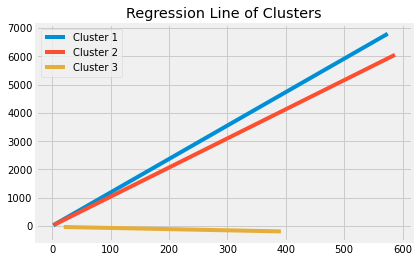

In [59]:
# visualise regression line for each cluster with unit price as x-axis

x1=np.arange(min(X1['unit_price']),max(X1['unit_price']))
x2=np.arange(min(X2['unit_price']),max(X2['unit_price']))
x3=np.arange(min(X3['unit_price']),max(X3['unit_price']))
y1 = 12.84+11.8*x1
y2 = 14.52+10.28*x2
y3 = -22.33-0.42*x3


# y1_pred=best_algo1.predict(X1_train)

sns.lineplot(x=x1, y=y1, label='Cluster 1', palette='colorblind')
sns.lineplot(x=x2, y=y2, label='Cluster 2', palette='colorblind')
sns.lineplot(x=x3, y=y3, label='Cluster 3', palette='colorblind')
plt.title("Regression Line of Clusters")
# plt.xlim(-10,400)
# plt.ylim(-100,1000)
plt.show()

From above, it is pretty clear that 

### Limitations and Other Considerations

Pure science, but there is an art to determining a price. eg. branding, marketing, advertising. 

### Further Development

